# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [13]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
from tqdm import tqdm
import time
import random

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [2]:
df_news = pd.read_csv('./data/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.
 
We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [3]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'], 
        'TICKER': row['TICKER'], 
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [6]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [7]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [8]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [9]:
# CODE HERE
# Use as many coding cells as you need
# Column validation and sampling
# Sample 100 distinct news


sampled_100 = df_news.sample(n=100, random_state=42)

# Displaying new DataFrame
display(sampled_100.head())
print(sampled_100.shape)


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
427,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1600,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
728,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3769,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
2711,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


(100, 7)


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [10]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()  # Loads variables from the .env file
api_key = os.getenv("KEY")  # Make sure your .env has: KEY=your_api_key_here

# Stop execution if the API key is missing
if not api_key:
    raise ValueError("The variable 'KEY' was not found in the .env file")

client = OpenAI(api_key = api_key)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn. MJR"
)

print(response.output_text)

In a hidden glade under the twinkling stars, a gentle unicorn named Luna danced among the flowers, spreading sweet dreams to all who slept nearby.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset. 

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [11]:
prompt = """
Given the news headline provided below, 
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [14]:
# CODE HERE
# Use as many coding cells as you need
# Function to generate a question with retries for rate limits
def gen_question_strict(news_text):
    # Generate ONE question using GPT; fail if empty
    resp = client.responses.create(
        model="gpt-4o-mini",
        input=prompt.format(news=news_text)
    )
    q = (resp.output_text or "").strip()
    if not q:
        raise RuntimeError("Empty question returned by the model. Re-run this cell.")
    return q

rows = []
# Progress bar while iterating over rows
for _, row in tqdm(sampled_100.iterrows(), total=len(sampled_100), desc="Generating questions"):
    # Use ONLY the summary to strictly follow the clarification
    news_blob = row["SUMMARY"]
    q = gen_question_strict(news_blob)
    rows.append({"NEWS": row["SUMMARY"], "QUESTION": q})

df_news_questions = pd.DataFrame(rows, columns=["NEWS", "QUESTION"])

# Validation: expect EXACTLY 100 rows and 100 unique questions
assert len(df_news_questions) == 100, f"Expected 100 rows, got {len(df_news_questions)}."
uniq = df_news_questions["QUESTION"].nunique()
assert uniq == 100, f"Questions must be unique (got {uniq}/100). Re-run if needed."

display(df_news_questions.head(10))
print("Rows:", len(df_news_questions), "| Unique questions:", uniq)

Generating questions: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls from Wall Street's t...
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have drawn attention ...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent news discusses Ventas' earnings re...
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for during N...
4,Inflation-scarred American consumers are putti...,What are American consumers doing in response ...
5,Delivery service DoorDash (DASH) reported its ...,What were the key financial results and market...
6,Strong capital efficiency and commercial growt...,What are the key factors affecting investor se...
7,Argus recently lowered the price target on Equ...,What recent actions did Argus take regarding t...
8,The Zacks Internet software industry participa...,What companies in the Zacks Internet software ...
9,This marks the ninth time in 37 years this uns...,What notable event has occurred for this compa...


Rows: 100 | Unique questions: 100


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [15]:
# CODE HERE
# Use as many coding cells as you need
# Function to retrieve top-k summaries from FAISS
def retrieve_topk(question: str, k: int = 5):
    """
    Query the FAISS vector store with a question and return the top-k SUMMARY strings.
    Higher similarity => higher rank (index 0 is the best match).
    """
    hits = faiss_store.search(question, k=k)   # [(doc, meta, score), ...]
    return [doc for (doc, meta, score) in hits]


In [16]:
ranks = []

# Progress bar while iterating over the evaluation dataset
for _, row in tqdm(df_news_questions.iterrows(), total=len(df_news_questions), desc="Evaluating baseline (no reranker)"):
    q = row["QUESTION"]
    top5 = retrieve_topk(q, k=5)          
    target = row["NEWS"]                  
    rank_val = top5.index(target) if target in top5 else "not found"
    ranks.append(rank_val)

df_news_questions["NO_RERANKER"] = ranks

print("Baseline NO_RERANKER rank distribution (0=best, 4=worst, 'not found'):")
print(df_news_questions["NO_RERANKER"].value_counts(dropna=False))
display(df_news_questions.head(10))


Evaluating baseline (no reranker): 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.68it/s]

Baseline NO_RERANKER rank distribution (0=best, 4=worst, 'not found'):
NO_RERANKER
0            91
not found     5
2             3
1             1
Name: count, dtype: int64


,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls from Wall Street's t...,0
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have drawn attention ...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent news discusses Ventas' earnings re...,0
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for during N...,0
4,Inflation-scarred American consumers are putti...,What are American consumers doing in response ...,0
5,Delivery service DoorDash (DASH) reported its ...,What were the key financial results and market...,2
6,Strong capital efficiency and commercial growt...,What are the key factors affecting investor se...,0
7,Argus recently lowered the price target on Equ...,What recent actions did Argus take regarding t...,0
8,The Zacks Internet software industry participa...,What companies in the Zacks Internet software ...,0
9,This marks the ninth time in 37 years this uns...,What notable event has occurred for this compa...,0


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [17]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218912  -4.0780277]


In [18]:
# CODE HERE
# Use as many coding cells as you need
with_reranker_ranks = []   # 0..4 or "not found"
top5_with_reranker = []    # store reranked top-5 for inspection

# Progress bar while applying the reranker
for _, row in tqdm(df_news_questions.iterrows(), total=len(df_news_questions), desc="Evaluating with reranker"):
    q = row["QUESTION"]
    target = row["NEWS"]

    # Retrieve top-100 candidates using the retriever
    top100 = retrieve_topk(q, k=100)

    # Score each (question, candidate) pair with the CrossEncoder
    pairs = [(q, cand) for cand in top100]
    scores = model.predict(pairs)  # higher = better match

    # Sort by score (descending), take top-5
    ranked = sorted(zip(top100, scores), key=lambda x: x[1], reverse=True)
    reranked_docs = [doc for (doc, sc) in ranked]
    top5 = reranked_docs[:5]
    top5_with_reranker.append(top5)

    # Record 0-based rank or "not found"
    rank_val = top5.index(target) if target in top5 else "not found"
    with_reranker_ranks.append(rank_val)

# Save results to DataFrame
df_news_questions["TOP5_WITH_RERANKER"] = top5_with_reranker
df_news_questions["WITH_RERANKER"] = with_reranker_ranks

print("WITH_RERANKER rank distribution (0=best, 4=worst, 'not found'):")
print(df_news_questions["WITH_RERANKER"].value_counts(dropna=False))
display(df_news_questions.head(10))

Evaluating with reranker: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]

WITH_RERANKER rank distribution (0=best, 4=worst, 'not found'):
WITH_RERANKER
0            93
1             2
3             2
2             2
not found     1
Name: count, dtype: int64


,NEWS,QUESTION,NO_RERANKER,TOP5_WITH_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What are the latest calls from Wall Street's t...,0,"[Broadcom, Arista Networks initiated: Wall Str...",0
1,Emerson Electric (EMR) has received quite a bi...,What recent developments have drawn attention ...,0,[Emerson Electric (EMR) has received quite a b...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent news discusses Ventas' earnings re...,0,[Ventas (VTR) reported earnings 30 days ago. W...,0
3,Nvidia's earnings call this week will be a mar...,What are the key factors to watch for during N...,0,[Nvidia's earnings call this week will be a ma...,0
4,Inflation-scarred American consumers are putti...,What are American consumers doing in response ...,0,[Inflation-scarred American consumers are putt...,0
5,Delivery service DoorDash (DASH) reported its ...,What were the key financial results and market...,2,[Delivery service DoorDash (DASH) reported its...,0
6,Strong capital efficiency and commercial growt...,What are the key factors affecting investor se...,0,[Strong capital efficiency and commercial grow...,0
7,Argus recently lowered the price target on Equ...,What recent actions did Argus take regarding t...,0,[Argus recently lowered the price target on Eq...,0
8,The Zacks Internet software industry participa...,What companies in the Zacks Internet software ...,0,[The Zacks Internet software industry particip...,0
9,This marks the ninth time in 37 years this uns...,What notable event has occurred for this compa...,0,[This marks the ninth time in 37 years this un...,0


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [19]:
# CODE HERE
# Use as many coding cells as you need
cats = [0, 1, 2, 3, 4, "not found"]
total = len(df_news_questions)

no_counts   = df_news_questions["NO_RERANKER"].value_counts().reindex(cats, fill_value=0)
with_counts = df_news_questions["WITH_RERANKER"].value_counts().reindex(cats, fill_value=0)

dist_table = pd.DataFrame({
    "NO_count":   no_counts,
    "WITH_count": with_counts,
})

dist_table.index.name = "Rank (0=best)"
display(dist_table)


,NO_count,WITH_count
Rank (0=best),,
0,91,93
1,1,2
2,3,2
3,0,2
4,0,0
not found,5,1


In [20]:
s_no   = df_news_questions["NO_RERANKER"]
s_with = df_news_questions["WITH_RERANKER"]
k = 5  # top-5 cutoff for penalizing "not found"

# Convert to numeric: 0..4; "not found" -> NaN
no_num   = pd.to_numeric(s_no, errors="coerce")
with_num = pd.to_numeric(s_with, errors="coerce")

# --- Metrics ---
# Hit@1: share at position 0 (higher = better)
hit1_no   = (s_no == 0).mean()
hit1_with = (s_with == 0).mean()

# Hit@5 (Coverage): share that are found anywhere in top-5 (higher = better)
hit5_no   = (s_no != "not found").mean()
hit5_with = (s_with != "not found").mean()

# Penalized average rank (1-based): 1..5 for found; "not found" -> 6 (lower = better)
pen_no_1b   = no_num.fillna(k).add(1).mean()
pen_with_1b = with_num.fillna(k).add(1).mean()

# Median rank (found only, 0-based): excludes "not found" (lower = better)
med_no_0b   = no_num.median()
med_with_0b = with_num.median()

# --- Summary table with interpretation column ---
summary = pd.DataFrame({
    "Metric": [
        "Hit@1 (position 0)",
        "Hit@5 (Coverage)",
        "Penalized avg rank (1-based)",
        "Median rank (found only, 0-based)"
    ],
    "NO_RERANKER": [
        f"{hit1_no:.2%}",
        f"{hit5_no:.2%}",
        f"{pen_no_1b:.3f}",
        f"{med_no_0b:.3f}" if pd.notna(med_no_0b) else "NaN"
    ],
    "WITH_RERANKER": [
        f"{hit1_with:.2%}",
        f"{hit5_with:.2%}",
        f"{pen_with_1b:.3f}",
        f"{med_with_0b:.3f}" if pd.notna(med_with_0b) else "NaN"
    ],
    "How to read it": [
        "Share of questions with the correct article ranked #1. Higher = better.",
        "Share of questions where the correct article appears within the top-5. Higher = better.",
        "Average rank using 1..5 for found items and 6 for 'not found'. Lower = better.",
        "Median of ranks 0..4 (excludes 'not found'). Lower = better."
    ]
})

pd.set_option('display.max_colwidth', None)
styled = summary.style.set_properties(subset=['How to read it'], **{'white-space': 'pre-wrap'})
display(styled)

,Metric,NO_RERANKER,WITH_RERANKER,How to read it
0,Hit@1 (position 0),91.00%,93.00%,Share of questions with the correct article ranked #1. Higher = better.
1,Hit@5 (Coverage),95.00%,99.00%,Share of questions where the correct article appears within the top-5. Higher = better.
2,Penalized avg rank (1-based),1.320,1.170,Average rank using 1..5 for found items and 6 for 'not found'. Lower = better.
3,"Median rank (found only, 0-based)",0.000,0.000,Median of ranks 0..4 (excludes 'not found'). Lower = better.


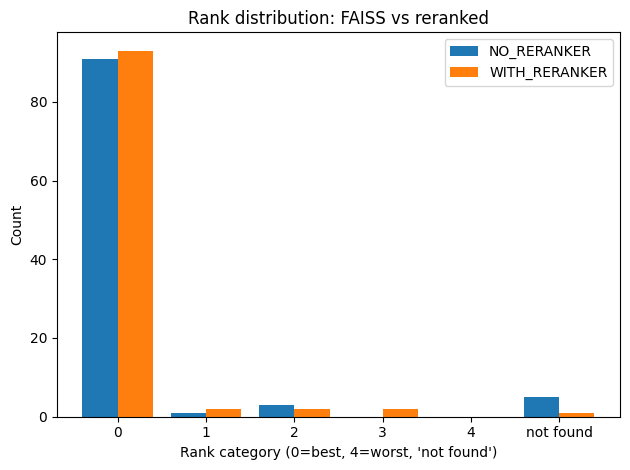

In [21]:
cats = [0, 1, 2, 3, 4, "not found"]
no_counts   = s_no.value_counts().reindex(cats, fill_value=0)
with_counts = s_with.value_counts().reindex(cats, fill_value=0)

x = range(len(cats))
width = 0.4

plt.figure()
plt.bar([i - width/2 for i in x], no_counts.values,   width=width, label="NO_RERANKER")
plt.bar([i + width/2 for i in x], with_counts.values, width=width, label="WITH_RERANKER")
plt.xticks(list(x), cats)
plt.xlabel("Rank category (0=best, 4=worst, 'not found')")
plt.ylabel("Count")
plt.title("Rank distribution: FAISS vs reranked")
plt.legend()
plt.tight_layout()
plt.show()

### **Question 1.** Did reranking improve the **average position** of the correct news?
 

 **Yes, reranking improved the average position.**

* The **penalized average rank (1-based)** dropped from **1.320 (no reranker)** to **1.170 (with reranker)** → lower is better.
* The number of “not found” cases decreased significantly from **5 (no reranker)** to **1 (with reranker)**.
* This shows that the reranker helped not only bring answers slightly closer to the top but also prevented missing the correct article in several cases.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


* **Without reranker (baseline FAISS):** the correct article was at position **0 in 91% of queries** (91/100).
* **With reranker (CrossEncoder):** this improved to **93% of queries** (93/100).

The reranker improved the **Hit\@1 metric** by +2 percentage points and almost eliminated the “not found” cases (from 5% → 1%).

Final

* **Average rank improved** (1.32 → 1.17).
* **Top-1 accuracy improved** (91% → 93%).
* **Coverage improved** (95% → 99% found in top-5).

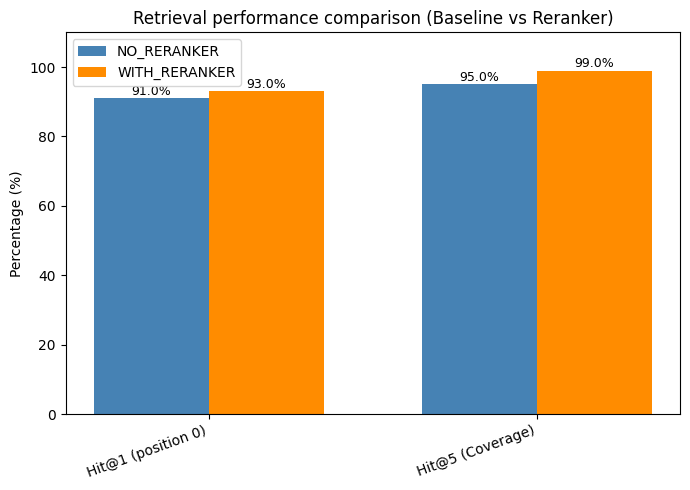

In [22]:
# Prepare metrics as percentages
metrics = ["Hit@1 (position 0)", "Hit@5 (Coverage)"]
values_no   = [hit1_no * 100, hit5_no * 100]
values_with = [hit1_with * 100, hit5_with * 100]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

# Bars for NO_RERANKER
ax.bar([i - width/2 for i in x], values_no, width, label="NO_RERANKER", color="steelblue")
# Bars for WITH_RERANKER
ax.bar([i + width/2 for i in x], values_with, width, label="WITH_RERANKER", color="darkorange")

# Formatting
ax.set_ylabel("Percentage (%)")
ax.set_title("Retrieval performance comparison (Baseline vs Reranker)")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=20, ha="right")
ax.set_ylim(0, 110)
ax.legend()

# Add labels on top of bars
for i, v in enumerate(values_no):
    ax.text(i - width/2, v + 1, f"{v:.1f}%", ha="center", fontsize=9)
for i, v in enumerate(values_with):
    ax.text(i + width/2, v + 1, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()